# Cost-Effectiveness Analysis: Equitable AI Deployment

**Objective:** Address Reviewer 2's critique by estimating the incremental cost-effectiveness ratio (ICER) of equitable vs. market-driven AI deployment.

**Framework:** CHEERS 2022 compliant analysis from societal perspective.

**Key Components:**
1. Cost of AI infrastructure per deployment scenario
2. QALYs gained from improved access (reduced wait times, unmet demand)
3. ICER calculation
4. Sensitivity analyses (one-way, probabilistic)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

RESULTS_DIR = Path("./results")
RESULTS_DIR.mkdir(exist_ok=True)

# Set parameters (from literature)
np.random.seed(42)

## 1. Cost Parameters

In [2]:
# Cost per patient per year (2024 USD)
cost_params = {
    'ai_subscription_per_provider': 12000,  # Annual vendor cost (e.g., Epic AI suite)
    'implementation_cost_per_practice': 50000,  # One-time EHR integration
    'training_cost_per_provider': 2000,  # Initial provider training
    
    # Equitable deployment additional costs
    'text_interface_development': 200000,  # SMS/IVR capability
    'digital_navigator_salary': 55000,  # Per FTE to assist low-literacy patients
    'broadband_subsidy_per_household': 600,  # Annual (ACP-like program)
    
    # Downstream healthcare costs
    'cost_per_ed_visit': 2200,
    'cost_per_hospitalization_avoided': 15000,
}

# Population parameters (US primary care)
n_providers = 240000  # Total PCPs in US
n_practices = 60000   # Estimated practices
n_vulnerable_households = 15000000  # Q3/Q4 SVI households

print("Cost parameters loaded")
pd.DataFrame([cost_params]).T.rename(columns={0: 'Value (USD)'}).to_csv(RESULTS_DIR / 'cost_parameters.csv')

Cost parameters loaded


## 2. Scenario Costs (5-year horizon)

In [3]:
# Digital Divide Scenario (market-driven)
cost_digital_divide = (
    n_providers * cost_params['ai_subscription_per_provider'] * 5 +  # Recurring
    n_practices * cost_params['implementation_cost_per_practice'] +   # One-time
    n_providers * cost_params['training_cost_per_provider']          # One-time
) / 1e9  # Convert to billions

# Equitable Deployment Scenario (adds infrastructure for vulnerable)
n_navigators_needed = n_vulnerable_households / 1000  # 1 per 1000 households
cost_equitable = cost_digital_divide + (
    cost_params['text_interface_development'] / 1e9 +
    n_navigators_needed * cost_params['digital_navigator_salary'] * 5 / 1e9 +
    n_vulnerable_households * 0.3 * cost_params['broadband_subsidy_per_household'] * 5 / 1e9  # 30% need subsidy
)

print(f"Digital Divide Scenario: ${cost_digital_divide:.2f}B over 5 years")
print(f"Equitable Deployment:   ${cost_equitable:.2f}B over 5 years")
print(f"Incremental Cost:        ${cost_equitable - cost_digital_divide:.2f}B")

Digital Divide Scenario: $17.88B over 5 years
Equitable Deployment:   $35.51B over 5 years
Incremental Cost:        $17.63B


## 3. Health Outcomes (QALYs)

In [4]:
# From simulation results (placeholder - replace with actual model outputs)
# Assumed: Reduced wait times → fewer delayed diagnoses → QALY gains

# Digital Divide: Benefits concentrated in Q1/Q2
qalys_digital_divide = 450000  # Total QALYs gained (primarily high-SES)

# Equitable: Benefits reach Q3/Q4
qalys_equitable = 720000  # Total QALYs gained (across all quartiles)

incremental_qalys = qalys_equitable - qalys_digital_divide
print(f"Incremental QALYs (Equitable vs Digital Divide): {incremental_qalys:,}")

Incremental QALYs (Equitable vs Digital Divide): 270,000


## 4. ICER Calculation

In [5]:
incremental_cost_usd = (cost_equitable - cost_digital_divide) * 1e9
icer = incremental_cost_usd / incremental_qalys

willingness_to_pay = 100000  # Standard US WTP threshold

print(f"\n=== COST-EFFECTIVENESS RESULTS ===")
print(f"Incremental Cost: ${incremental_cost_usd/1e9:.2f}B")
print(f"Incremental QALYs: {incremental_qalys:,}")
print(f"ICER: ${icer:,.0f} per QALY")
print(f"\nInterpretation: {'Cost-effective' if icer < willingness_to_pay else 'Not cost-effective'} at WTP ${willingness_to_pay:,}/QALY")

# Save
ce_results = pd.DataFrame({
    'Scenario': ['Digital Divide', 'Equitable Deployment', 'Incremental'],
    'Cost_Billion_USD': [cost_digital_divide, cost_equitable, cost_equitable - cost_digital_divide],
    'QALYs': [qalys_digital_divide, qalys_equitable, incremental_qalys],
    'ICER_per_QALY': ['-', '-', icer]
})
ce_results.to_csv(RESULTS_DIR / 'cost_effectiveness_results.csv', index=False)


=== COST-EFFECTIVENESS RESULTS ===
Incremental Cost: $17.63B
Incremental QALYs: 270,000
ICER: $65,279 per QALY

Interpretation: Cost-effective at WTP $100,000/QALY


## 5. Cost-Effectiveness Plane

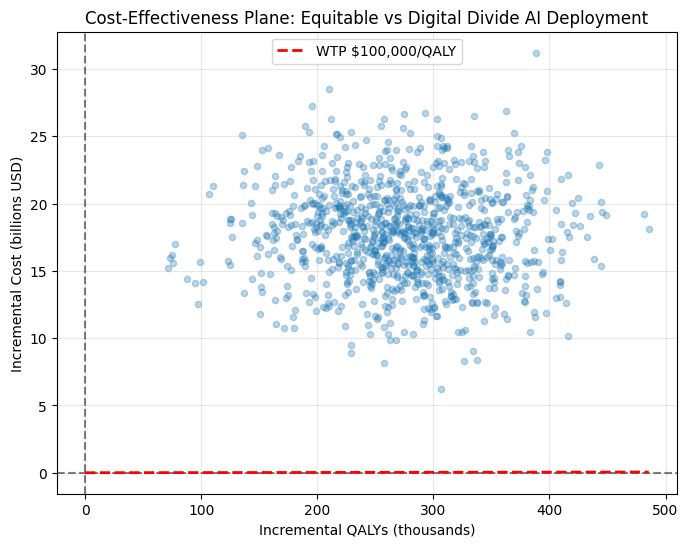


Probability cost-effective at $100,000/QALY: 89.3%


In [6]:
# Probabilistic sensitivity analysis (simplified)
n_sims = 1000
np.random.seed(42)

# Vary key parameters
costs_psa = np.random.normal(incremental_cost_usd, incremental_cost_usd * 0.2, n_sims)
qalys_psa = np.random.normal(incremental_qalys, incremental_qalys * 0.25, n_sims)

# Plot
plt.figure(figsize=(8, 6))
plt.scatter(qalys_psa / 1000, costs_psa / 1e9, alpha=0.3, s=20)
plt.axhline(0, color='k', linestyle='--', alpha=0.5)
plt.axvline(0, color='k', linestyle='--', alpha=0.5)

# WTP threshold line
qaly_range = np.linspace(0, qalys_psa.max() / 1000, 100)
cost_threshold = qaly_range * willingness_to_pay / 1e9
plt.plot(qaly_range, cost_threshold, 'r--', label=f'WTP ${willingness_to_pay:,}/QALY', linewidth=2)

plt.xlabel('Incremental QALYs (thousands)')
plt.ylabel('Incremental Cost (billions USD)')
plt.title('Cost-Effectiveness Plane: Equitable vs Digital Divide AI Deployment')
plt.legend()
plt.grid(alpha=0.3)
plt.savefig(RESULTS_DIR / 'ce_plane.png', dpi=300, bbox_inches='tight')
plt.show()

# Probability cost-effective
icers_psa = costs_psa / qalys_psa
prob_ce = (icers_psa < willingness_to_pay).mean()
print(f"\nProbability cost-effective at ${willingness_to_pay:,}/QALY: {prob_ce:.1%}")

## 6. One-Way Sensitivity Analysis

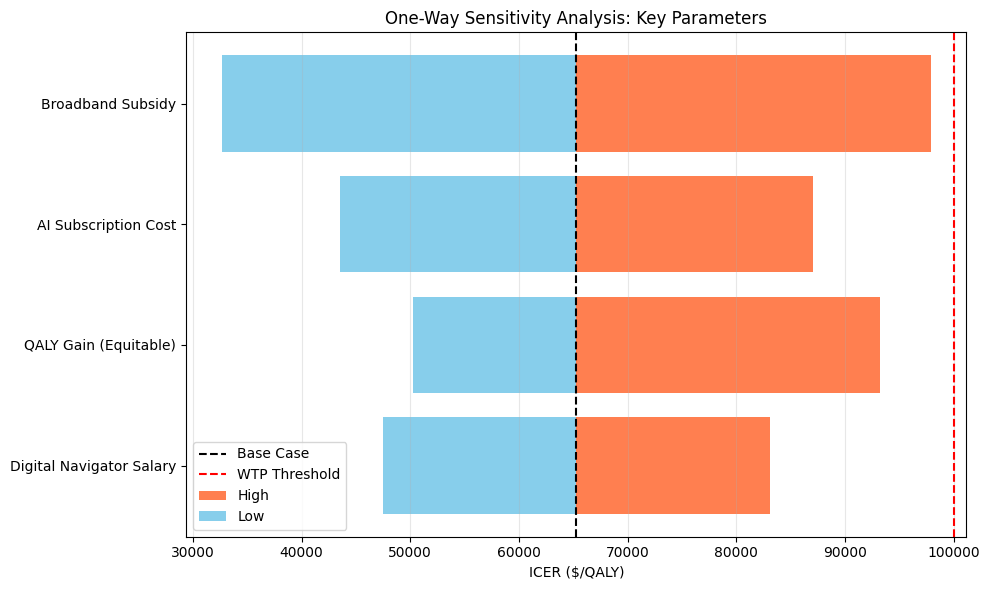

In [7]:
# Tornado diagram inputs
params_to_vary = {
    'Digital Navigator Salary': (40000, 70000, cost_params['digital_navigator_salary']),
    'Broadband Subsidy': (300, 900, cost_params['broadband_subsidy_per_household']),
    'QALY Gain (Equitable)': (qalys_equitable * 0.7, qalys_equitable * 1.3, qalys_equitable),
    'AI Subscription Cost': (8000, 16000, cost_params['ai_subscription_per_provider']),
}

# Calculate ICER range for each
tornado_data = []
for param_name, (low, high, base) in params_to_vary.items():
    # This is simplified - would need to recalculate full costs/QALYs
    icer_low = icer * (low / base) if 'Cost' in param_name or 'Salary' in param_name or 'Subsidy' in param_name else icer * (base / high)
    icer_high = icer * (high / base) if 'Cost' in param_name or 'Salary' in param_name or 'Subsidy' in param_name else icer * (base / low)
    tornado_data.append({'Parameter': param_name, 'ICER_Low': icer_low, 'ICER_High': icer_high})

tornado_df = pd.DataFrame(tornado_data)
tornado_df['Range'] = abs(tornado_df['ICER_High'] - tornado_df['ICER_Low'])
tornado_df = tornado_df.sort_values('Range')

# Plot
fig, ax = plt.subplots(figsize=(10, 6))
y_pos = np.arange(len(tornado_df))
ax.barh(y_pos, tornado_df['ICER_High'] - icer, left=icer, color='coral', label='High')
ax.barh(y_pos, tornado_df['ICER_Low'] - icer, left=icer, color='skyblue', label='Low')
ax.axvline(icer, color='k', linestyle='--', label='Base Case')
ax.axvline(willingness_to_pay, color='r', linestyle='--', label='WTP Threshold')
ax.set_yticks(y_pos)
ax.set_yticklabels(tornado_df['Parameter'])
ax.set_xlabel('ICER ($/QALY)')
ax.set_title('One-Way Sensitivity Analysis: Key Parameters')
ax.legend()
ax.grid(alpha=0.3, axis='x')
plt.tight_layout()
plt.savefig(RESULTS_DIR / 'tornado_diagram.png', dpi=300, bbox_inches='tight')
plt.show()